<h1 align="center">Lab 5 - Kohonen Net and Manifolds  </font> </h1>

<h2 align="center">2. Local Linear Embedding with Translated Face Patches </h2> 

In this Lab, you will implement local linear embedding algorithm and apply it to a dataset contains translated face patches. We start from the visualization of the dataset. And this experiment is based on an introductory paper by Saul & Paul, which is uploaded to the bcourse with the name 'LLE_tutorial'. Please read the paper before you do this problem.

In [2]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from utils.lab5_utils import LLE_util
import pdb
import operator
import numpy.linalg as la

In [3]:
# Load face data
faces = np.load('./data/yalefaces.npz')['faces'].T
# Load LLE support library class
LLE_support = LLE_util()
# Generate a dataset
data = LLE_support.generate_data(faces)

Each column from the dataset is a face patch on a random noise background. The Following line plots a single image from the generated dataset:

<IPython.core.display.Javascript object>


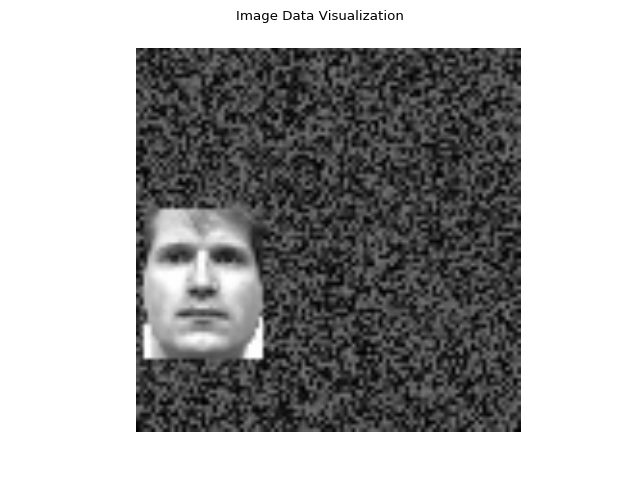

In [4]:
LLE_support.plotImgSamples(data[:,0:1])

And to get a sense of the whole dataset, let sample and plot 100 images from it.

<IPython.core.display.Javascript object>


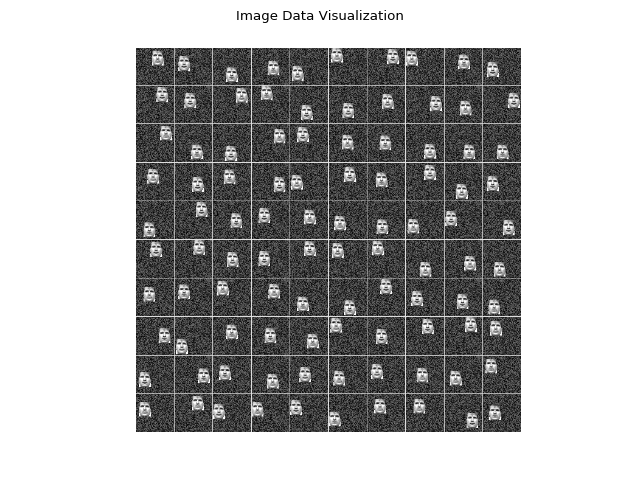

In [5]:
LLE_support.plotImgSamples(data[:,100:200])

Now, let start to implement local linear embedding algorithm. For your convinience, I have provided a distance function that computes pairwise Euclidean distance for each pair of data vectors.

In [6]:
dis = LLE_support.compute_pairwise_distance(data)

<h2 align="center">2.1 K Nearest Neighbors </h2> 

Please implement a k nearest neighbor function: for each image vector, find K nearest neighbors for it. Let's make the value K = 4 for visualization purpose.

In [7]:
def K_nearest_neighbors(dis, K = 4):
    dataNum = dis.shape[0]
    
    # find indicies of the K nearest neighbors
    # indexing from 1 because 0 is itself
    neighbors = np.array([np.argsort(row)[1:K+1] for row in dis])

    return neighbors.T

In [8]:
neighbors = K_nearest_neighbors(dis)

Let's visualize the nearest neighbors for image 0 and you should compare these neighbors with the image shown at the beginning to make sure these neighbors are reasonable. Please give a brief explanation.

**Brief Explanation**

When calculating the pairwise euclidian distance, images that are more similar pixel by pixel will have shorter distances. Because of correlations between nearby pixels in the face (the faces are identical, just translated), translating a face just a small amount will not change its euclidian distance that much; that means that faces translated a small amount will be more likely to be nearest neighbors. As we can see, the nearest neighbors it finds are indeed the faces that are in a very similar location spatially as the input.

<IPython.core.display.Javascript object>


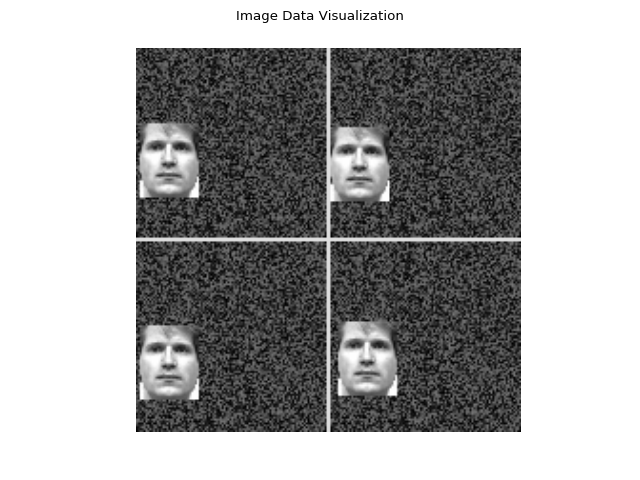

In [9]:
knn0 = data[:,neighbors[:,0]]
LLE_support.plotImgSamples(knn0)

<h2 align="center"> 2.2 Local Linear Interpolation Graph</h2> 

After you get the K nearest neighbors for each of the images in the dataset. The next step is to find a local linear interpolation by using the neighbors. Please implement the following function, which returns the interpolation graph. Tips: 1. Each of the column of W should sum to 1 since we are using linear interpolations. 2. For each of the column, only the neighbors have non-zeros weight, the rest should be zero.

In [10]:
def local_embedding_graph(data,neighbors):
    dataNum = data.shape[1]
    K = neighbors.shape[0]
    W = np.zeros([dataNum,dataNum])
    
    for i in range(dataNum):
        vec = data[:,i:i+1]
        knn_vec = data[:,neighbors[:,i]]

        # minimize vec - W.T @ knn_vec
        # with constraints W[i, neighbors[:, i]] = 0 and W[neigbors[:, i], i] = 0
        # and np.all(np.sum(W, axis=1) == 1)
        C = (vec - knn_vec).T @ (vec - knn_vec)
        
        # Make matrix invertible
        delta = 0.1 * np.trace(C)
        C += (np.power(delta, 2) / K) * np.eye(K)
        
        # solve Cw=1
        b = np.ones(K)
        w = np.linalg.solve(C, b)
        
        # norm so sum is 1
        w = w / np.sum(w)
        
        W[neighbors[:, i], i] = w
    
    return W

In [11]:
W = local_embedding_graph(data,neighbors)

For a sanity check, let visaulize the reconstruction of image 0 by the K nearest neighbors. Please give an explaination of what you see.

**Explanation of what I see**

I see a blurry face at about the location of image 0. That image is actually a weighted interpolation between the four nearest neighbors that I saw earlier, with the weights chosen to minimize the reconstruction error to the true image 0.

<IPython.core.display.Javascript object>


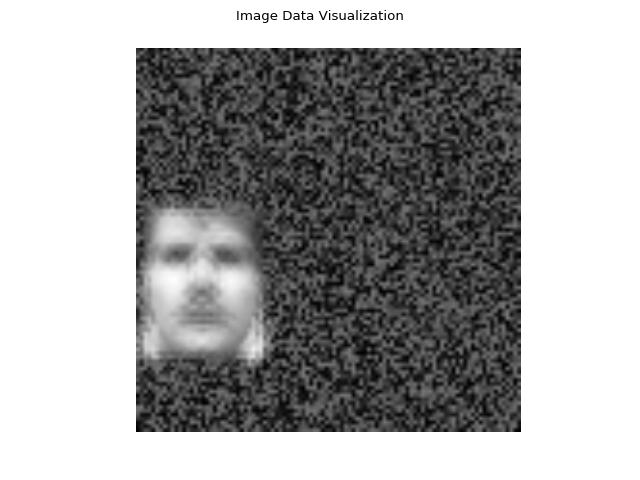

In [12]:
im0_rectr = data @ W[:,0:1]
LLE_support.plotImgSamples(im0_rectr)

<h2 align="center"> 2.3 LLE Manifold Mapping</h2> 

After we have computed the nearest-neighbor linear interpolation graph W. The last step is to project each image vector to a low dimesional space. In this problem, we will project our dataset to 2 dimensional space, but in general you should explore the best dimensionality. Please explain the result.

**Explanation of the result**

After projecting our dataset into 2 dimensional space, we see what is almost a perfect flat square with a little bit higher density at the edges. In step one, we learned weights that defined how each datapoint related to its nearest neighbors. This projection produces 2D vectors that preserve that relationship for each datapoint.

The reason for higher density at the edges is probably that faces at the edge will be primarily reconstructed using its neighbors also on the edge (for example on the left edge, the faces located above and below), and give less weight to its neighbor towards the center because there will not be another face on the other side to cancel it out. Thus, faces along the edge will be "closer" to each other in terms of our learned weights $W$ because they are less likely to use their inward neighbors to produce a good reconstruction. I don't know if I explained that well but okay.

In [13]:
def LLE_manifold_mapping(W,d = 2):
    dataNum = W.shape[0]
    
    # calculate eigenvectors of the M matrix (I-W)'(I-W)
    eigenvals, eigenvecs = np.linalg.eig((np.eye(dataNum) - W.T).T @ (np.eye(dataNum) - W.T))
    
    # take the two bottom eigenvectors after excluding the bottom one
    manifold = eigenvecs[:,np.argsort(eigenvals)[1:d+1]].T
    
    return manifold

In [14]:
manifold = LLE_manifold_mapping(W)

Finally, we should visualize the mapping and see if that corresponds to a 2-D translation map.

<IPython.core.display.Javascript object>


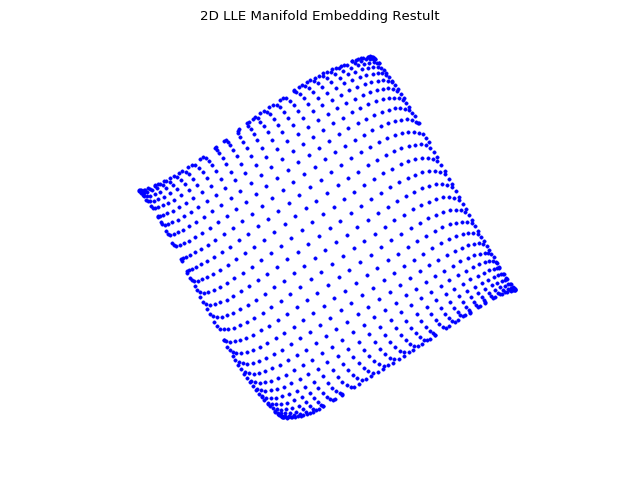

In [15]:
LLE_support.LLE_2D_plot(manifold)